# Overturning Circulation
Overturning circulation in density space using ty_trans_rho.

## Theory

## Calculation

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from tqdm import tqdm_notebook

In [2]:
from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [3]:
cc.start_cluster(diagnostics_port=8787)

Run this command on a local terminal to set up SSH tunnels for dashboard:

  ssh -N -L 8787:127.0.0.1:8787 vdi-n11.nci.org.au -l jm0634


Client Scheduler: tcp://127.0.0.1:37859 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [4]:
@memory.cache
def calc_psi_avg(expt, n=4):
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                             chunks={'potrho': None},
                             n=n)

    psi = psi.sum('grid_xt_ocean').cumsum('potrho')
    psi_avg = psi.mean('time')
    
    #psi_avg = psi_avg.compute()
    psi_avg = cc.compute_by_block(psi_avg)
    
    return psi_avg

In [5]:
expts = cc.get_experiments('mom01v5')[:4]
expts

['GFDL50', 'KDS75', 'KDS75_PI', 'KDS75_UP']

In [6]:
expt = 'KDS75'

In [7]:
%%time
psi_avg = calc_psi_avg(expt)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

CPU times: user 9.66 s, sys: 1.38 s, total: 11 s
Wall time: 35.4 s


In [8]:
def plot_psi(psi_avg, expt, clev=np.arange(-20,20,2)):

    plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

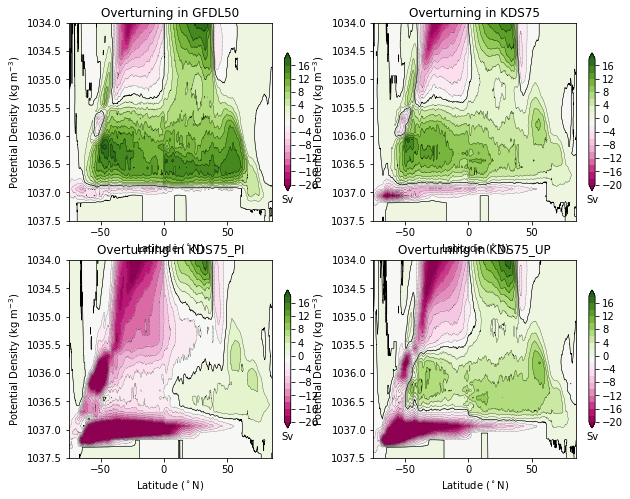

In [10]:
plt.figure(figsize=(10,8))
for n, expt in enumerate(expts): 
    plt.subplot(2,2,n+1)
    psi_avg = calc_psi_avg(expt)
    plot_psi(psi_avg, expt)